### Read datasets

In [1]:
# Read data from Yfinance
import yfinance as yf
list_tick1 = ['ETH-USD']
df1 = yf.download(list_tick1,  start = "2021-01-01" , end = "2022-12-11", interval = '1h')

print(df1.shape)
df1[-5:]

[*********************100%***********************]  1 of 1 completed
(16784, 6)


,Open,High,Low,Close,Adj Close,Volume
2022-12-10 16:00:00+00:00,"1,277.03","1,279.53","1,274.90","1,274.90","1,274.90",45010688
2022-12-10 17:00:00+00:00,"1,274.92","1,275.43","1,269.79","1,269.79","1,269.79",0
2022-12-10 18:00:00+00:00,"1,269.75","1,272.42","1,269.29","1,272.34","1,272.34",0
2022-12-10 19:00:00+00:00,"1,272.41","1,273.44","1,271.73","1,272.35","1,272.35",0
2022-12-10 20:00:00+00:00,"1,272.28","1,273.16","1,271.80","1,272.76","1,272.76",0


In [2]:
# Read data from cexa
url = 'https://cexa.oceanprotocol.io/ohlc?exchange=binance&pair=ETH/USDT&period=1h'
df = pd.read_json(url)
df.columns = ['dt1','open','high','low','close','volume']
# convert to UTC+0
a = [dt.fromtimestamp(x/1000) - relativedelta(hours=3) for x in df.dt1]
df['dt1'] = a

print(df.shape)
df[-3:]

(1000, 6)


,dt1,open,high,low,close,volume
997,2022-12-11 10:00:00,"1,271.99","1,273.70","1,271.08","1,272.79","4,741.53"
998,2022-12-11 11:00:00,"1,272.79","1,273.62","1,271.13","1,273.45","4,095.57"
999,2022-12-11 12:00:00,"1,273.44","1,273.75","1,271.72","1,272.78","2,080.20"


### Comparing

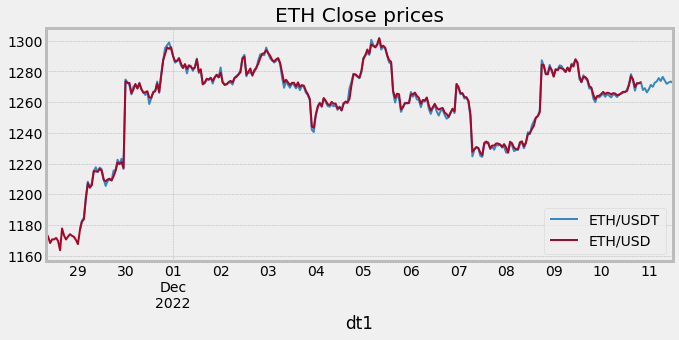

In [8]:
# USD is not USDT but very similar
plt.style.use('bmh')
_ = df.set_index('dt1')[-300:].close.plot(figsize = (10,4), title = 'ETH Close prices')
_ = df1.Close[-300:].plot(figsize = (10,4))
_ = plt.legend(['ETH/USDT','ETH/USD'])

### Prophet model to eliminate trends and seasons

In [4]:
from prophet import Prophet
df1.index = pd.to_datetime(df1.index.map(lambda x: str(x).split('+')[0]))

# 1) prepare dataframe
x = df1.Close
x = x.reset_index()
x.columns = ['ds','y']

# 2) build model
m = Prophet(weekly_seasonality=True, daily_seasonality=True, )
m.fit(x)

# 3) predict
df_out = m.predict(x)
df1['Close_pred'] = df_out.set_index('ds')['yhat']
df1['Close_diff'] = df1.Close - df1.Close_pred

print(df1.shape)
display(df1[-5:])
df1.to_pickle('../data/ETH_USD.pkl')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


(16784, 8)


,Open,High,Low,Close,Adj Close,Volume,Close_pred,Close_diff
2022-12-10 16:00:00,"1,277.03","1,279.53","1,274.90","1,274.90","1,274.90",45010688,"1,210.79",64.11
2022-12-10 17:00:00,"1,274.92","1,275.43","1,269.79","1,269.79","1,269.79",0,"1,210.51",59.28
2022-12-10 18:00:00,"1,269.75","1,272.42","1,269.29","1,272.34","1,272.34",0,"1,210.02",62.32
2022-12-10 19:00:00,"1,272.41","1,273.44","1,271.73","1,272.35","1,272.35",0,"1,209.66",62.69
2022-12-10 20:00:00,"1,272.28","1,273.16","1,271.80","1,272.76","1,272.76",0,"1,209.83",62.93
